# Title

## Setup

In [3]:
import pandas as pd
from ast import literal_eval
import pandas as pd
from pathlib import Path
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.utils import simple_preprocess
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path
data_folder = Path.cwd().parent / 'data'
import seaborn as sns

In [4]:
book_df = pd.read_csv('https://raw.githubusercontent.com/malcolmosh/goodbooks-10k/master/books_enriched.csv', index_col=[0], converters={"genres": literal_eval})
book_df.description=book_df.description.fillna('')

In [13]:
book_df_reduced=book_df.loc[:,["book_id","description"]]
#rename book_id to isbn
book_df_reduced.rename(columns={"book_id":"isbn"},inplace=True)
book_df_reduced.isna().any()

isbn           False
description    False
dtype: bool

In [14]:
#save to csv
book_df_reduced.to_csv(data_folder/"exp_books.csv",index=False)

In [5]:
book_df.language_code.value_counts()

language_code
eng    9680
ara      64
de       33
fre      25
es       21
ind      21
spa      20
fr       18
it       13
ger      13
nl        7
per       7
da        7
ro        7
jpn       7
pl        6
pol       6
sv        6
por       6
mt        3
nor       3
dan       3
ms        3
cs        2
fil       2
ita       2
rum       1
fi        1
lt        1
rus       1
zh        1
no        1
mul       1
vie       1
swe       1
is        1
id        1
tur       1
hu        1
af        1
et        1
Name: count, dtype: int64

## Train a doc2vec model

In [ ]:
training_corpus = np.empty(len(book_df), dtype=object)
for i, (isbn, desc) in tqdm(enumerate(zip(book_df.index, book_df['description']))):
    training_corpus[i] = TaggedDocument(simple_preprocess(desc), [str(i)])
model=Doc2Vec(vector_size=50, min_count=5, epochs=40)
model.build_vocab(training_corpus)
#train the model
model.train(training_corpus, total_examples=model.corpus_count, epochs=model.epochs)
#get the keys of the trained model
model_keys=list(model.dv.key_to_index.keys())
matrix = model.dv.vectors

10000it [00:02, 3881.99it/s]


In [ ]:
#calculate the average number of words in the documents
average_words = np.mean([len(x.words) for x in training_corpus])
average_words

147.0422

## Create a similarity matrix

In [ ]:
similarity_matrix = cosine_similarity(matrix)

In [ ]:
similarity_matrix.shape

(10000, 10000)

<Axes: ylabel='Count'>

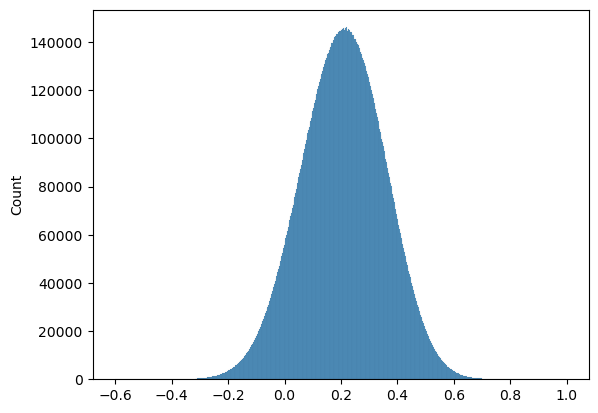

In [ ]:
#get the upper triangle of the similarity matrix
upper_triangle = similarity_matrix[np.triu_indices(similarity_matrix.shape[0], k=1)]
#plot the histogram
sns.histplot(upper_triangle)

## Visualize the similarities between languages

In [ ]:
indices_for_language = {}
for language, group_df in book_df.groupby('language_code'):
    indices_for_language[language] = group_df.index.to_list()
indices_for_language.keys()

dict_keys(['af', 'ara', 'cs', 'da', 'dan', 'de', 'eng', 'es', 'et', 'fi', 'fil', 'fr', 'fre', 'ger', 'hu', 'id', 'ind', 'is', 'it', 'ita', 'jpn', 'lt', 'ms', 'mt', 'mul', 'nl', 'no', 'nor', 'per', 'pl', 'pol', 'por', 'ro', 'rum', 'rus', 'spa', 'sv', 'swe', 'tur', 'vie', 'zh'])

### French and indonesian

<Axes: >

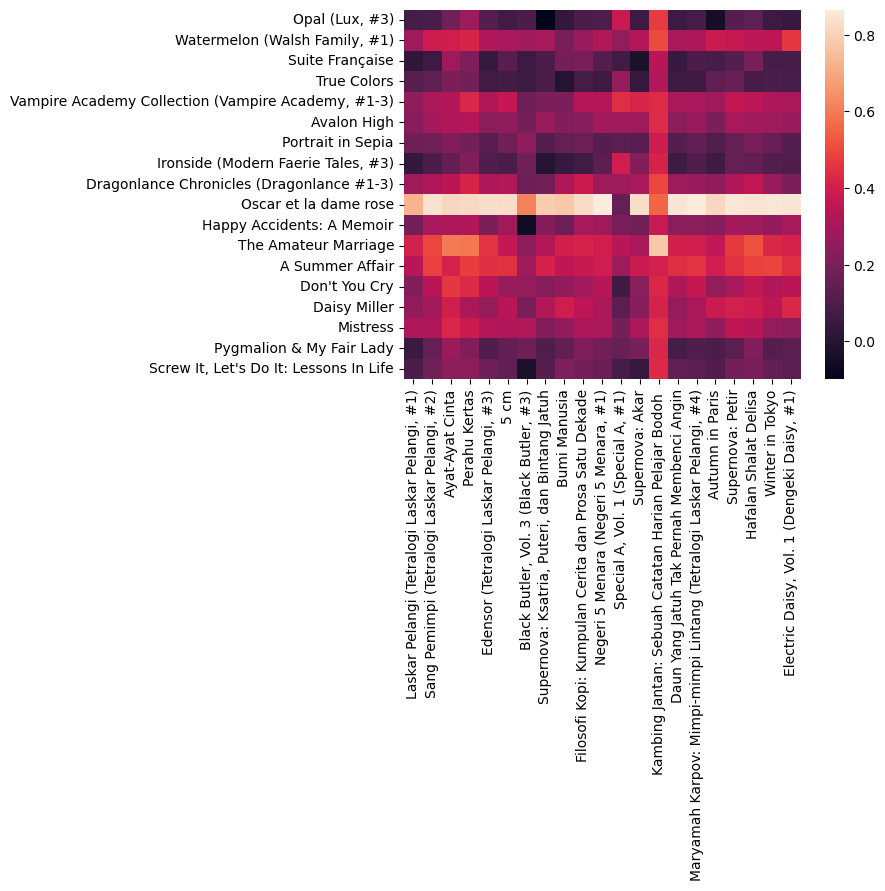

In [ ]:
sim_french_indonesian = similarity_matrix[indices_for_language['fr']][:, indices_for_language['ind']]
sim_french_indonesian.shape
#make a heatmap
sns.heatmap(sim_french_indonesian,xticklabels=book_df.iloc[indices_for_language['ind']]['title'],yticklabels=book_df.iloc[indices_for_language['fr']]['title'])

### German and Arabic

<Axes: >

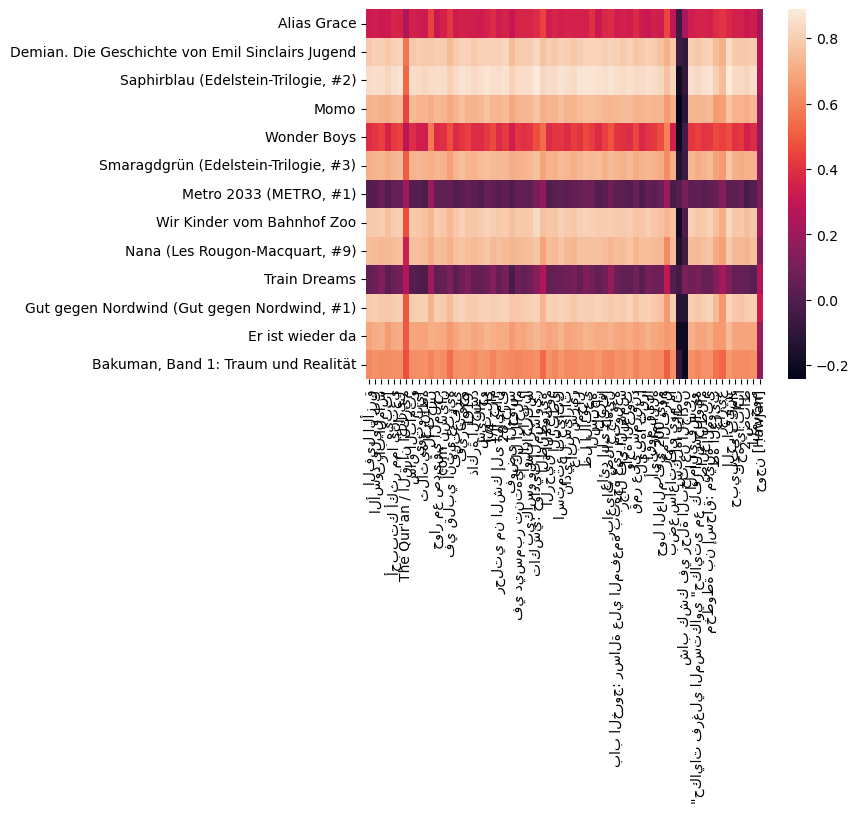

In [ ]:
sim_german_arabic = similarity_matrix[indices_for_language['ger']][:, indices_for_language['ara']]
#make a heatmap
sns.heatmap(sim_german_arabic,xticklabels=book_df.iloc[indices_for_language['ara']]['title'],yticklabels=book_df.iloc[indices_for_language['ger']]['title']) 

In [ ]:
#print all arabic words and the words most similar to them
for index in indices_for_language['ara']:
    words=training_corpus[index].words
    #find the most similar word to each word
    for word in words:
        try:
            similar_word=model.wv.most_similar(word)
            print("Current word: ", word)
            print("Most similar word: ", similar_word)
        except:
            continue

Current word:  بعد
Most similar word:  [('ذلك', 0.9980592727661133), ('لها', 0.9976945519447327), ('هذه', 0.9976107478141785), ('فيها', 0.9976097345352173), ('وقد', 0.9974145889282227), ('مع', 0.9973469972610474), ('فى', 0.9973140954971313), ('قد', 0.9972773194313049), ('كنت', 0.9972293972969055), ('إلا', 0.997189998626709)]
Current word:  من
Most similar word:  [('في', 0.9977198243141174), ('أن', 0.9964444637298584), ('على', 0.9964183568954468), ('هذا', 0.9956910610198975), ('ما', 0.9954285025596619), ('لا', 0.9948902726173401), ('التي', 0.9947208762168884), ('إلى', 0.9936293363571167), ('عن', 0.9934417009353638), ('الذي', 0.993313729763031)]
Current word:  في
Most similar word:  [('من', 0.9977197647094727), ('على', 0.9972959756851196), ('أن', 0.99658203125), ('التي', 0.9961973428726196), ('لا', 0.9961192607879639), ('ما', 0.9954240918159485), ('الذي', 0.9948614835739136), ('إلى', 0.9939612746238708), ('عن', 0.9938890337944031), ('النسيان', 0.9935460686683655)]
Current word:  حيث
Most

In [ ]:
ratings_df = pd.read_csv('https://raw.githubusercontent.com/malcolmosh/goodbooks-10k/master/ratings.csv')
ratings_df.head()

user_id  book_id  rating
0        1      258       5
1        2     4081       4
2        2      260       5
3        2     9296       5
4        2     2318       3

In [ ]:
#save to csv
ratings_df.to_csv(data_folder / 'exp_ratings.csv', index=False)